Multiple LSTMs (Self-contained)

This notebook builds a stacked LSTM sentiment model on IMDB using **TensorFlow Datasets** + **TextVectorization** (so it runs locally in VS Code/Jupyter without extra vocab files).

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
print(tf.__version__)

2.20.0


## Load IMDB (tfds)

In [2]:
# Will download on first run to the default tfds data dir (usually ~/.tensorflow_datasets)
(train_ds, test_ds), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='C:\\Users\\user\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <S

In [3]:
import os
os.environ["TFDS_DATA_DIR"] = "D:/TFDS_DATA"

## Vectorize Text

In [4]:
VOCAB_SIZE = 10000
SEQ_LEN = 200

vectorize = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQ_LEN,
)

# Adapt only on the text (x) part
text_only = train_ds.map(lambda x, y: x)
vectorize.adapt(text_only.batch(1024))

def vectorize_batch(text, label):
    #text = tf.squeeze(text)  # ensure scalar strings
    text = tf.expand_dims(text, -1)   # ( ) -> (1,)
    return vectorize(text), label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

train_vec = (
    train_ds
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .map(vectorize_batch, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
test_vec = (
    test_ds
    .batch(BATCH_SIZE)
    .map(vectorize_batch, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

## Build Stacked LSTM Model

In [5]:
EMBED_DIM = 64
LSTM1 = 64
LSTM2 = 32
DENSE = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SEQ_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2)),
    tf.keras.layers.Dense(DENSE, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)
model.summary()

D:\PythonEnvs\master_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train

In [ ]:
EPOCHS = 3
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
]
history = model.fit(train_vec, epochs=EPOCHS, validation_data=test_vec, callbacks=callbacks)

Epoch 1/3
144/196 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.6124 - loss: 0.6274

## Plot

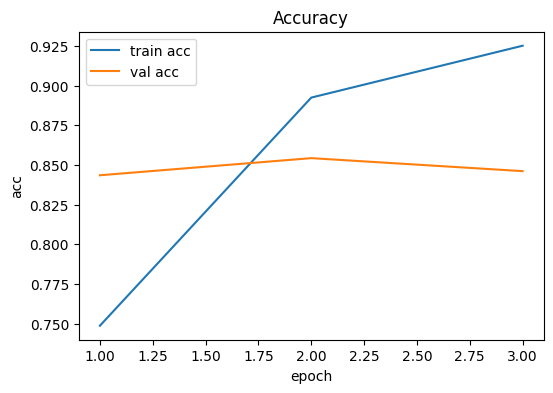

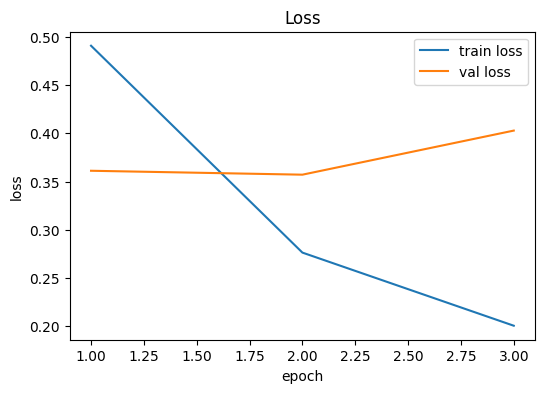

In [8]:
def plot_history(h):
    acc = h.history['accuracy']; val_acc = h.history['val_accuracy']
    loss = h.history['loss']; val_loss = h.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, acc, label='train acc')
    plt.plot(epochs, val_acc, label='val acc')
    plt.title('Accuracy'); plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.title('Loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.show()

plot_history(history)

## Save Artifacts

In [9]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model.save(f'imdb_lstm_{timestamp}.keras')
with open('metrics.txt', 'w') as f:
    f.write(str(history.history))
print('Saved model and metrics.')

Saved model and metrics.


## Notes
- Stacked BiLSTM: first with `return_sequences=True`, second without (to get a summary vector).
- Replace `EPOCHS`/`SEQ_LEN`/`VOCAB_SIZE` to experiment.
- This is intentionally simple and portable for VS Code + Jupyter.